In [1]:
#importing packages
import warnings
warnings.filterwarnings("ignore")

import pickle
import os
import random
import pandas as pd
import random as rn
import numpy as np
import tensorflow as tf
# tf.enable_eager_execution()

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.regularizers import l1,l2
from tqdm import tqdm
import heapq
from sklearn.utils import shuffle
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ast
from sklearn.model_selection import train_test_split

In [2]:
train_images = 'train2014/train2014'
val_images = 'val2014/val2014'
test_images = 'test2015/test2015'
img_width = 448
img_height = 448

BATCH_SIZE = 64
BUFFER_SIZE = 300

In [3]:
data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')
test_data = pd.read_csv('test_data.csv')

In [4]:
data.dropna(inplace = True)
val_data.dropna(inplace = True)
test_data.dropna(inplace = True)

In [5]:
contractions = { 
"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not",
"couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he's": "he is","how'd": "how did",
"how'll": "how will","how's": "how is","i'd": "i would","i'll": "i will","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would",
"it'll": "it will","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"must've": "must have","mustn't": "must not","needn't": "need not","oughtn't": "ought not","shan't": "shall not","sha'n't": "shall not","she'd": "she would",
"she'll": "she will","she's": "she is","should've": "should have","shouldn't": "should not","that'd": "that would","that's": "that is","there'd": "there had",
"there's": "there is","they'd": "they would","they'll": "they will","they're": "they are","they've": "they have","wasn't": "was not","we'd": "we would",
"we'll": "we will","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what're": "what are","what's": "what is",
"what've": "what have","where'd": "where did","where's": "where is","who'll": "who will","who's": "who is","won't": "will not","wouldn't": "would not",
"you'd": "you would","you'll": "you will","you're": "you are"
}

def preprocess_text(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = ""
    text = text.lower()
    i = 0
    for word in text.split():
        if i==0:
            new_text = contractions.get(word,word)
        else:
            new_text = new_text + " " + contractions.get(word,word)
        i += 1
    return new_text.replace("'s", '')

In [6]:
data['multiple_choice_answer'] = data['multiple_choice_answer'].apply(lambda x: preprocess_text(x))
val_data['multiple_choice_answer'] = val_data['multiple_choice_answer'].apply(lambda x: preprocess_text(x))

In [7]:
X_train = data
X_val = val_data
X_test = test_data

del data, val_data, test_data
len(X_train), len(X_val), len(X_test)

(443749, 214349, 447793)

In [8]:
all_classes = X_train['multiple_choice_answer'].values
class_frequency = {}

for _cls in all_classes:
    if(class_frequency.get(_cls,-1)>0):
        class_frequency[_cls] += 1
    else:
        class_frequency[_cls] = 1

In [9]:
common_tags = heapq.nlargest(1000, class_frequency, key = class_frequency.get)

In [10]:
# take the top 1000 classes
X_train['multiple_choice_answer'] =  X_train['multiple_choice_answer'].apply(lambda x: x if x in common_tags else '')

# removing question which has empty tags
X_train = X_train[X_train['multiple_choice_answer'].apply(lambda x: len(x)>0)]

In [11]:
label_encoder = LabelBinarizer()
answer_vector_train = label_encoder.fit_transform(X_train['multiple_choice_answer'].apply(lambda x: x).values)
answer_vector_val = label_encoder.transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)

ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}

print("Number of clasess: ", len(ans_vocab))
print("Shape of Answer Vectors in Train Data: ", answer_vector_train.shape)
print("Shape of Answer Vectors in Validation Data: ", answer_vector_val.shape)

Number of clasess:  1000
Shape of Answer Vectors in Train Data:  (388247, 1000)
Shape of Answer Vectors in Validation Data:  (214349, 1000)


### Question vectors

In [12]:
def preprocess_question(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = "<start>"
    text = text.lower()
    for word in text.split():
        new_text = new_text + " " + contractions.get(word, word)
    new_text = new_text + " <end>"
    return new_text.replace("'s", '')

In [13]:
X_train['question'] = X_train['question'].apply(lambda x: preprocess_question(x))
X_val['question'] = X_val['question'].apply(lambda x: preprocess_question(x))

In [14]:
#tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(X_train['question'].values)
train_question_seqs = tokenizer.texts_to_sequences(X_train['question'].values)

print("Number of words in tokenizer:", len(tokenizer.word_index))
ques_vocab = tokenizer.word_index

question_vector_train = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')
print("Shape of Question Vectors in Train Data: ", question_vector_train.shape)

Number of words in tokenizer: 12449
Shape of Question Vectors in Train Data:  (388247, 24)


### Model


In [18]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_width, img_height))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    img = img * (1./255)
    img = tf.expand_dims(img, axis=0)
    return img, image_path

def VGG_Top():
    model = tf.keras.applications.VGG19(include_top = False,
                                            weights="imagenet",
                                            input_shape = (img_width, img_height,3))
    
    input_layer = model.input
    hidden_layer = model.layers[-1].output 
    model = tf.keras.Model(input_layer, hidden_layer)
    return model

In [34]:
class CoattentionModel(tf.keras.layers.Layer):
    def __init__(self):#, num_embeddings, num_classes, embed_dim=512, k=30
        super().__init__()
        self.num_classes = len(ans_vocab)
        self.hidden_size = 512
        self.dropout = 0.3
        self.num_embeddings = len(ques_vocab)+2

        self.image_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)) 
        self.image_corr = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=29))

        self.image_atten_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=17)) 
        self.question_atten_dens = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=28))
        self.question_atten_dropout = tf.keras.layers.Dropout(self.dropout)
        self.image_atten_dropout = tf.keras.layers.Dropout(self.dropout)

        self.ques_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=21))

        self.img_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=33))

        self.embed = tf.keras.layers.Embedding(self.num_embeddings, self.hidden_size,
                                               embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))
        
        self.unigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=41))
        self.bigram_conv  = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 2, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=58), dilation_rate = 2)
        self.trigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=89), dilation_rate = 2)
        self.max_pool = tf.keras.layers.MaxPool2D((3,1))
        self.phrase_dropout = tf.keras.layers.Dropout(self.dropout)
        
        self.lstm = tf.keras.layers.LSTM(units = 512 , return_sequences=True, dropout = self.dropout,
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54))
        
        self.tanh = tf.keras.layers.Activation('tanh')
        self.softmax = tf.keras.layers.Activation('softmax')
        
        self.W_w_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_p_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_s_dropout = tf.keras.layers.Dropout(self.dropout)

        self.W_w = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=32), input_shape = (self.hidden_size,))
        self.W_p = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=49), input_shape = (2 * self.hidden_size, ))
        self.W_s = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=31), input_shape = (2 * self.hidden_size, ))
        
        self.fc1_Dense = tf.keras.layers.Dense(units = 2 * self.hidden_size, activation='relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=84))
        self.fc1_dropout = tf.keras.layers.Dropout(self.dropout)

        self.fc = tf.keras.layers.Dense(units = self.num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.glorot_uniform(seed=91), input_shape = (self.hidden_size,))
        
        return

    def call(self, image, question):#Image: B x 196 x 512
        
        image = self.image_dense(image)
        image = self.tanh(image)

        words = self.embed(question)    # Words: B x L x 51

        unigrams =  tf.expand_dims(self.tanh(self.unigram_conv(words)), 1) # B x L x 512
        bigrams  =  tf.expand_dims(self.tanh(self.bigram_conv(words)), 1)  # B x L x 512
        trigrams =  tf.expand_dims(self.tanh(self.trigram_conv(words)), 1) # B x L x 512

        phrase = tf.squeeze(self.max_pool(tf.concat((unigrams, bigrams, trigrams), 1)), axis=1)  # B x L x 512
        phrase = self.tanh(phrase)
        phrase = self.phrase_dropout(phrase)
  
        hidden = None
        sentence = self.lstm(phrase)        # B x L x 512   

        print(words.shape, phrase.shape, sentence.shape)
        v_word, q_word = self.co_attention(image, words)
        v_phrase, q_phrase = self.co_attention(image, phrase)
        v_sent, q_sent = self.co_attention(image, sentence)

        h_w = self.tanh(self.W_w(self.W_w_dropout(q_word + v_word)))
        h_p = self.tanh(self.W_p(self.W_p_dropout(tf.concat(((q_phrase + v_phrase), h_w), axis=1))))
        h_s = self.tanh(self.W_s(self.W_s_dropout(tf.concat(((q_sent + v_sent), h_p), axis=1))))

        fc1 = self.fc1_Dense(self.fc1_dropout(h_s))
        logits = self.fc(fc1)

        return logits

    def co_attention(self, img_feat, ques_feat):  # V : B x 512 x 196, Q : B x L x 512
        img_corr = self.image_corr(img_feat)

        weight_matrix = tf.keras.backend.batch_dot(ques_feat, img_corr, axes = (2, 2))
        weight_matrix = self.tanh(weight_matrix)

        ques_embed = self.image_atten_dense(ques_feat)
        img_embed = self.question_atten_dens(img_feat)

        transform_img = tf.keras.backend.batch_dot(weight_matrix, img_embed)

        ques_atten_sum = self.tanh(transform_img + ques_embed)
        ques_atten_sum = self.question_atten_dropout(ques_atten_sum)
        ques_atten = self.ques_atten(ques_atten_sum)
        ques_atten =  tf.keras.layers.Reshape((ques_atten.shape[1],))(ques_atten)
        ques_atten =  self.softmax(ques_atten)

        transform_ques = tf.keras.backend.batch_dot(weight_matrix, ques_embed, axes = (1, 1))
        img_atten_sum = self.tanh(transform_ques+img_embed)
        img_atten_sum = self.image_atten_dropout(img_atten_sum)
        img_atten = self.img_atten(img_atten_sum)
        img_atten = tf.keras.layers.Reshape((img_atten.shape[1],))(img_atten)
        img_atten = self.softmax(img_atten)

        ques_atten = tf.keras.layers.Reshape(( 1, ques_atten.shape[1]))(ques_atten)
        img_atten = tf.keras.layers.Reshape(( 1, img_atten.shape[1]))(img_atten)

        ques_atten_feat = tf.keras.backend.batch_dot(ques_atten,ques_feat)
        print(ques_atten_feat)
        ques_atten_feat = tf.keras.layers.Reshape(( ques_atten_feat.shape[-1],))(ques_atten_feat)

        img_atten_feat =  tf.keras.backend.batch_dot(img_atten, img_feat)
        print(img_atten_feat)
        img_atten_feat = tf.keras.layers.Reshape((img_atten_feat.shape[-1],))(img_atten_feat)

        return img_atten_feat, ques_atten_feat

In [20]:
def Build_CoattentionModel():
    image_input1 = tf.keras.layers.Input(shape = (14,14, 512))
    image_input = tf.keras.layers.Reshape((-1, 512))(image_input1)

    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    output = CoattentionModel()(image_input, question_input)#num_embeddings = len(ques_vocab), num_classes = len(ans_vocab), embed_dim = 512

    model = tf.keras.models.Model(inputs = [image_input1, question_input], outputs = output)
    return model

In [38]:
def generate_on_test(model):
    random.seed(42)
    test_idx = np.random.randint(len(X_val), size = 20)
    model_vgg = VGG_Top()
    k = 5

    for idx in test_idx:
        test_image_id = X_test['image_id'].values[idx]
        test_question = X_test['question'].values[idx]
        test_image_path = test_images + '/COCO_test2015_' + '%012d.jpg' % (test_image_id)

        test_image_features = model_vgg(load_image(test_image_path)[0], 0)
        test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([test_question]),padding='post',
                                                                               maxlen=question_vector_train.shape[1])
        y_pred = model.predict([test_image_features,test_question_features])

        class_indices = tf.math.top_k(y_pred,k=k).indices.numpy()
        percentages = tf.math.top_k(y_pred,k=k).values.numpy()[0] * 100
        predictions = []
        for idx,i in enumerate(class_indices[0]):
            classes = np.zeros((1,1000))
            classes[0][i] = 1
            predictions.append((label_encoder.inverse_transform(classes)[0],percentages[idx]))

        img = mpimg.imread(test_image_path)
        imgplot = plt.imshow(img)
        plt.axis('off')
        plt.show()

        print("Question :", test_question.replace("<start> ","").replace(" <end>",""))
        print("Top Predicted answers: ",predictions)
        print("*"*100)

In [39]:
def generate_on_val(model):
    random.seed(42)
    test_idx = np.random.randint(len(X_val), size = 20)
    model_vgg = VGG_Top()
    k = 5

    for idx in test_idx:
        test_image_id = X_val['image_id'].values[idx]
        test_question = X_val['question'].values[idx]
        actual_answer = X_val['multiple_choice_answer'].values[idx]
        test_image_path = val_images + '/COCO_val2014_' + '%012d.jpg' % (test_image_id)

        test_image_features = model_vgg(load_image(test_image_path)[0], 0)
        test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([test_question]),padding='post',
                                                                               maxlen=question_vector_train.shape[1])
        y_pred = model.predict([test_image_features,test_question_features])

        class_indices = tf.math.top_k(y_pred,k=k).indices.numpy()
        percentages = tf.math.top_k(y_pred,k=k).values.numpy()[0] * 100
        predictions = []
        for idx,i in enumerate(class_indices[0]):
            classes = np.zeros((1,1000))
            classes[0][i] = 1
            predictions.append((label_encoder.inverse_transform(classes)[0],percentages[idx]))

        img = mpimg.imread(test_image_path)
        imgplot = plt.imshow(img)
        plt.axis('off')
        plt.show()

        print("Question :", test_question.replace("<start> ","").replace(" <end>",""))
        print("Actual Answer: ", actual_answer)
        print("Top Predicted answers: ",predictions)
        print("*"*100)

In [44]:
image_paths_train = X_train['image_id'].apply(lambda x: train_images + '/COCO_train2014_' + '%012d.jpg' % (x)).values
image_paths_val = X_val['image_id'].apply(lambda x:  val_images + '/COCO_val2014_' + '%012d.jpg' % (x)).values


In [25]:
with open('train_image_dict.pickle', 'rb') as handle:
    all_image_dict = pickle.load(handle)
    

In [26]:
with open('val_image_dict.pickle', 'rb') as handle:
    val_image_dict = pickle.load(handle)

In [27]:
# Get keys
oldkeys = list(all_image_dict.keys())
# Change "item" to "object"
newkeys = [s.replace('Train', 'train2014/train2014') for s in oldkeys]
# Get values
vals = list(all_image_dict.values())
# Create new dictionary by iterating over both newkeys and vals
all_image_dict = {k: v for k, v in zip(newkeys, vals)}

In [28]:
# Get keys
oldkeys = list(val_image_dict.keys())
# Change "item" to "object"
newkeys = [s.replace('Val', 'val2014/val2014') for s in oldkeys]
# Get values
vals = list(val_image_dict.values())
# Create new dictionary by iterating over both newkeys and vals
val_image_dict = {k: v for k, v in zip(newkeys, vals)}

In [29]:
all_image_dict.update(val_image_dict)

In [46]:
image_paths_val

array(['val2014/val2014/COCO_val2014_000000262148.jpg',
       'val2014/val2014/COCO_val2014_000000262148.jpg',
       'val2014/val2014/COCO_val2014_000000262148.jpg', ...,
       'val2014/val2014/COCO_val2014_000000393212.jpg',
       'val2014/val2014/COCO_val2014_000000393212.jpg',
       'val2014/val2014/COCO_val2014_000000393212.jpg'], dtype=object)

In [49]:
def get_imageTensor(img, ques, qtype, answer,atype,answers):
    img_tensor = all_image_dict[img.decode('utf-8')]
    img_tensor = tf.squeeze(img_tensor)
    return img_tensor, ques, qtype, answer, atype, answers

def createDataset(image_paths,question_vector,question_type,answer_vector,answer_type,answers):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, question_vector.astype(np.float32), question_type,answer_vector,answer_type,answers))

    # using map to load the numpy files in parallel
    dataset = dataset.map(lambda img, ques, qtype, answer, atype,answers : tf.numpy_function(get_imageTensor, [img, ques, qtype, answer, atype,answers], 
                                                                                     [tf.float32, tf.float32, tf.string, tf.int32, tf.string,tf.string]),
                                      num_parallel_calls = tf.data.experimental.AUTOTUNE)
    # shuffling and batching
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    return dataset

# image_paths_val = X_val['image_id'].apply(lambda x:  val_imageDirectory + 'COCO_val2014_' + '%012d.jpg' % (x)).values
answer_vector_val = label_encoder.transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)
# answer_vector_val = answer_vector_val.toarray()
answer_type = X_val['answer_type'].values 
answers = X_val['answers'].values

val_question_seqs = tokenizer.texts_to_sequences(X_val['question'].values)
question_vector_val = tf.keras.preprocessing.sequence.pad_sequences(val_question_seqs,padding='post',maxlen=24)

question_type = X_val['question_type'].values 

dataset_val = createDataset(image_paths_val, question_vector_val, question_type, answer_vector_val,answer_type,answers)



def model_metric(predictions, truths):
    total = 0
    correct_val = 0.0
    for prediction, truth in tqdm(zip(predictions, truths)):
        truth = ast.literal_eval(truth.numpy().decode('utf-8'))#json.loads(truth.numpy().decode('utf-8').replace("\'", "\""))
        prediction = label_encoder.inverse_transform(np.array([prediction]))[0]
        temp_count = 0
        total += 1
        for _truth in truth:
            if prediction == _truth['answer']:
                temp_count += 1
        # accuracy = min((# humans that provided that answer/3) , 1)
        if temp_count > 2:
            correct_val += 1
        else:
            correct_val += float(temp_count) / 3
    return (correct_val / total)*100

def print_accuracy_metrics(model):
    error_dict = {  _qtype : { 'top_1' : 0,'top_2' : 0,'top_3' : 0 ,'top_5' : 0,'count' : 0 } for _qtype in np.unique(question_type) }
    actual_list = []
    pred_list = []

    for (batch, (img_tensor, question, qtype, answer,atype,answers)) in tqdm(enumerate(dataset_val)):
        y_pred = model.predict([img_tensor,question])

        for i in range(y_pred.shape[0]):
            _qtype = qtype[i].numpy().decode('utf-8')
            _atype = atype[i].numpy().decode('utf-8')
            error_dict[_qtype]['count'] += 1 

            for _k in [1]:#[1,2,3,5]:
                if _atype == 'yes/no' and _k > 1:
                    top_k = tf.math.top_k(y_pred, k = 1).indices.numpy()[i]
                else:
                    top_k = tf.math.top_k(y_pred, k = _k).indices.numpy()[i]

                pred_classes = np.zeros(y_pred.shape[1])
                pred_classes[top_k] = 1
                actual_list.append(answers[i])
                pred_list.append(pred_classes)
                
    print("Accuracy : " + str(model_metric(pred_list, actual_list)))


In [51]:
model = Build_CoattentionModel()
model.load_weights('Models/coattention.h5')

(None, 24, 512) (None, 24, 512) (None, 24, 512)
Tensor("coattention_model_4/MatMul_3:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_4/MatMul_4:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_4/MatMul_8:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_4/MatMul_9:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_4/MatMul_13:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_4/MatMul_14:0", shape=(None, 1, 512), dtype=float32)


(None, 24, 512) (None, 24, 512) (None, 24, 512)
Tensor("model_2/coattention_model_2/MatMul_3:0", shape=(None, 1, 512), dtype=float32)
Tensor("model_2/coattention_model_2/MatMul_4:0", shape=(None, 1, 512), dtype=float32)
Tensor("model_2/coattention_model_2/MatMul_8:0", shape=(None, 1, 512), dtype=float32)
Tensor("model_2/coattention_model_2/MatMul_9:0", shape=(None, 1, 512), dtype=float32)
Tensor("model_2/coattention_model_2/MatMul_13:0", shape=(None, 1, 512), dtype=float32)
Tensor("model_2/coattention_model_2/MatMul_14:0", shape=(None, 1, 512), dtype=float32)


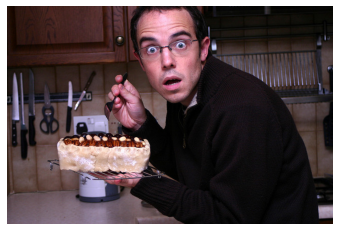

Question : Is this man insane?
Top Predicted answers:  [('yes', 57.470108), ('no', 42.293518), ('night', 0.11714546), ('open', 0.027381824), ('closed', 0.019976554)]
****************************************************************************************************


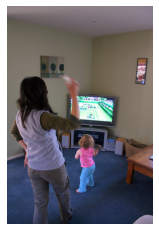

Question : Is there an adult and child in the image?
Top Predicted answers:  [('no', 37.887028), ('yes', 36.72865), ('man', 3.7077148), ('boy', 2.4581778), ('woman', 2.2967122)]
****************************************************************************************************


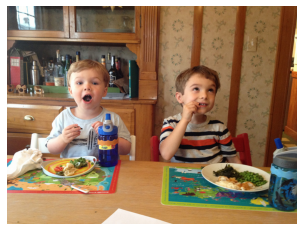

Question : Do the boys have matching placemats?
Top Predicted answers:  [('yes', 58.38516), ('no', 41.008476), ('1', 0.18628752), ('2', 0.12698677), ('3', 0.03139267)]
****************************************************************************************************


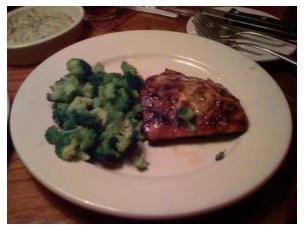

Question : What is the side item on the plate?
Top Predicted answers:  [('food', 10.57949), ('pizza', 8.053764), ('fries', 7.957567), ('sandwich', 6.917849), ('salad', 5.5769563)]
****************************************************************************************************


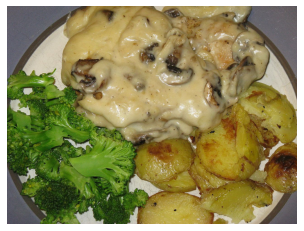

Question : Is this a vegetarian meal?
Top Predicted answers:  [('no', 51.40647), ('yes', 48.53884), ('1', 0.016605213), ('0', 0.0120640285), ('2', 0.0037976431)]
****************************************************************************************************


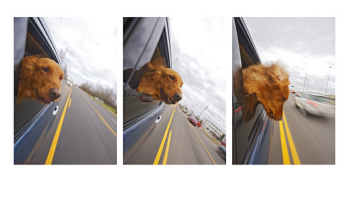

Question : Is the car moving?
Top Predicted answers:  [('no', 11.907948), ('yes', 11.860596), ('0', 2.5073633), ('red', 2.4944067), ('white', 2.0669844)]
****************************************************************************************************


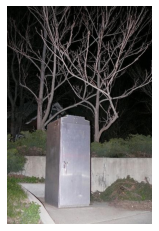

Question : Are those pebbles around the tree?
Top Predicted answers:  [('yes', 13.429703), ('no', 12.026924), ('0', 2.117411), ('natural', 1.350483), ('front', 1.2907529)]
****************************************************************************************************


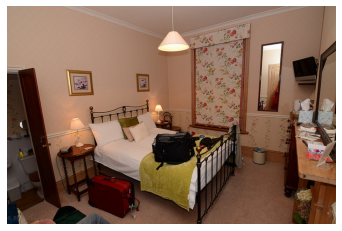

Question : What color is the bed 's comforter?
Top Predicted answers:  [('white', 31.101748), ('black', 20.588829), ('brown', 15.156311), ('blue', 10.076968), ('gray', 4.9236856)]
****************************************************************************************************


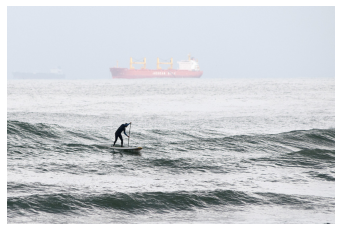

Question : Is he surfing?
Top Predicted answers:  [('yes', 68.25143), ('no', 25.461214), ('surfing', 5.8568053), ('wetsuit', 0.1411966), ('ocean', 0.08410803)]
****************************************************************************************************


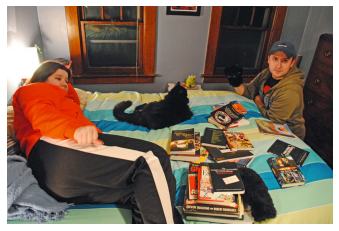

Question : What is under the head of the child?
Top Predicted answers:  [('suitcase', 5.63319), ('hat', 5.094796), ('pillow', 4.6529455), ('umbrella', 4.603397), ('keyboard', 4.4997535)]
****************************************************************************************************


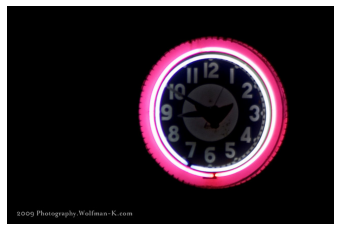

Question : Are the numbers written in Roman numerals?
Top Predicted answers:  [('0', 16.223413), ('1', 8.809862), ('2', 8.522955), ('3', 6.475351), ('5', 5.1545978)]
****************************************************************************************************


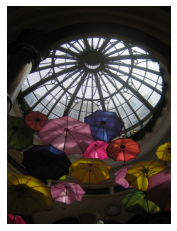

Question : Is this indoor?
Top Predicted answers:  [('fire hydrant', 3.1084867), ('stop sign', 2.8155725), ('kite', 2.2127035), ('pictures', 2.1301432), ('sign', 2.0674348)]
****************************************************************************************************


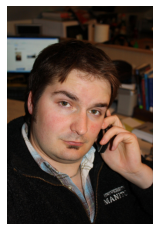

Question : Does the man have a mustache?
Top Predicted answers:  [('yes', 55.183918), ('no', 44.789993), ('1', 0.010272693), ('2', 0.0071802954), ('boy', 0.0010345124)]
****************************************************************************************************


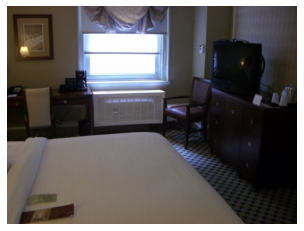

Question : Does this room have carpet?
Top Predicted answers:  [('yes', 51.357037), ('no', 48.47526), ('black and white', 0.052657526), ('closed', 0.014323904), ('night', 0.008649048)]
****************************************************************************************************


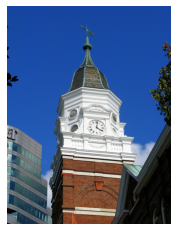

Question : Is the building all one color?
Top Predicted answers:  [('yes', 60.685165), ('no', 39.30404), ('brown', 0.0020614737), ('red', 0.0013022673), ('white', 0.0012501968)]
****************************************************************************************************


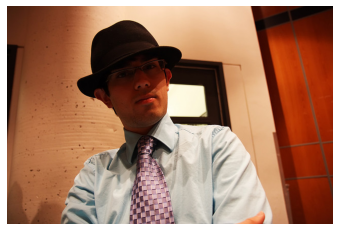

Question : Is he wearing a cowboy hat?
Top Predicted answers:  [('no', 64.09666), ('yes', 35.903343), ('1', 2.8973395e-07), ('2', 8.11965e-08), ('0', 7.1800774e-09)]
****************************************************************************************************


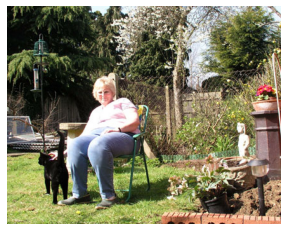

Question : What type of pants does the lady have on?
Top Predicted answers:  [('jeans', 80.8725), ('black', 3.3134959), ('cargo', 2.8424933), ('leather', 2.6326046), ('none', 1.8000464)]
****************************************************************************************************


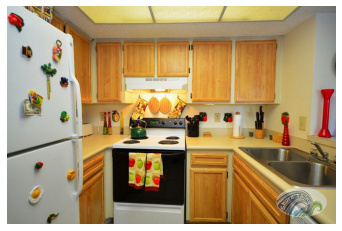

Question : Is the kitchen clean?
Top Predicted answers:  [('yes', 49.17001), ('no', 25.437107), ('clean', 3.9085112), ('open', 2.196241), ('dirty', 1.0655733)]
****************************************************************************************************


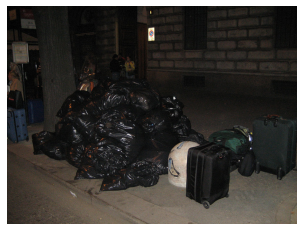

Question : Is it dark or light out?
Top Predicted answers:  [('dark', 53.30619), ('light', 15.574624), ('go', 9.968386), ('yes', 5.3110905), ('sun', 5.160426)]
****************************************************************************************************


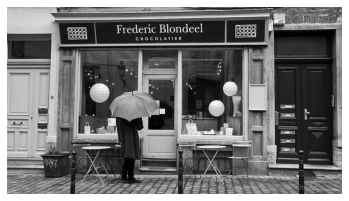

Question : What is the address number of building?
Top Predicted answers:  [('3', 10.368566), ('2', 10.160503), ('4', 9.295782), ('5', 7.7543917), ('1', 6.960792)]
****************************************************************************************************


In [40]:
generate_on_test(model)

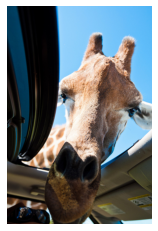

Question : does the animal stink?
Actual Answer:  yes
Top Predicted answers:  [('yes', 62.947838), ('no', 37.052162), ('1', 4.1622936e-08), ('2', 9.467204e-09), ('hat', 1.1368463e-09)]
****************************************************************************************************


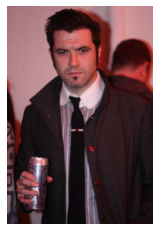

Question : is he wearing a hat?
Actual Answer:  no
Top Predicted answers:  [('no', 55.54821), ('yes', 44.45179), ('1', 6.1360186e-07), ('2', 9.231724e-08), ('0', 3.4746705e-08)]
****************************************************************************************************


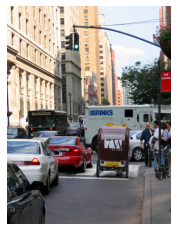

Question : what is the color of the glowing traffic light?
Actual Answer:  green
Top Predicted answers:  [('red', 66.80796), ('green', 23.41766), ('yellow', 8.173193), ('white', 1.0922873), ('red and yellow', 0.1431633)]
****************************************************************************************************


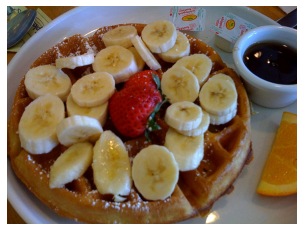

Question : is this food able to be prepared on a grill?
Actual Answer:  no
Top Predicted answers:  [('no', 50.234337), ('yes', 49.765656), ('1', 4.7045123e-06), ('2', 1.1151117e-06), ('cake', 3.876436e-07)]
****************************************************************************************************


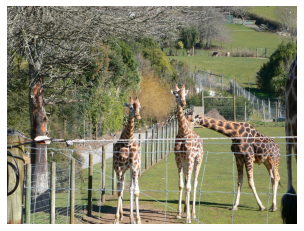

Question : what is in the foreground?
Actual Answer:  fence
Top Predicted answers:  [('giraffe', 64.51943), ('fence', 6.417979), ('giraffes', 5.7493205), ('elephant', 4.13438), ('tree', 2.976837)]
****************************************************************************************************


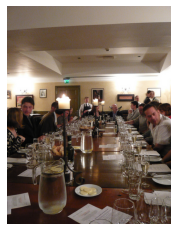

Question : has the meal been served?
Actual Answer:  no
Top Predicted answers:  [('yes', 55.710445), ('no', 44.289555), ('1', 5.898822e-08), ('2', 4.2280508e-08), ('lunch', 2.6418226e-08)]
****************************************************************************************************


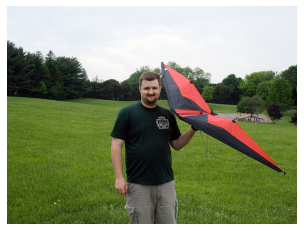

Question : is the grass lush and full?
Actual Answer:  yes
Top Predicted answers:  [('yes', 51.805477), ('no', 48.194473), ('day', 1.3915171e-05), ('green', 1.039623e-05), ('0', 5.178909e-06)]
****************************************************************************************************


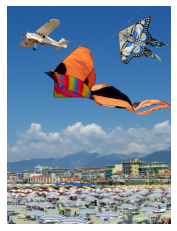

Question : is the beach crowded?
Actual Answer:  yes
Top Predicted answers:  [('yes', 52.5334), ('no', 47.466602), ('1', 1.7095749e-06), ('2', 3.9817536e-07), ('afternoon', 1.2678767e-07)]
****************************************************************************************************


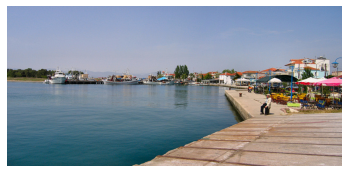

Question : are any of the boats moving?
Actual Answer:  no
Top Predicted answers:  [('no', 54.454113), ('yes', 45.545788), ('1', 3.419024e-05), ('day', 2.779732e-05), ('0', 1.6353299e-05)]
****************************************************************************************************


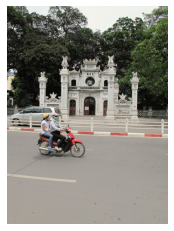

Question : how many people are on the bike?
Actual Answer:  2
Top Predicted answers:  [('1', 31.405476), ('2', 21.377087), ('0', 17.672972), ('3', 10.873758), ('4', 5.7885256)]
****************************************************************************************************


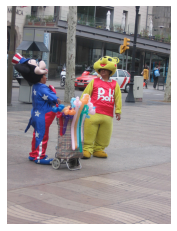

Question : how many white stars are on the costume?
Actual Answer:  4
Top Predicted answers:  [('0', 23.821781), ('1', 21.585007), ('2', 20.293753), ('3', 12.331968), ('4', 7.217203)]
****************************************************************************************************


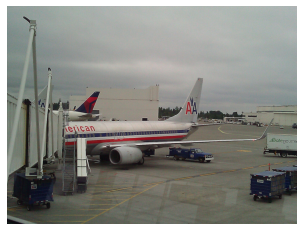

Question : what is the logo on the plane?
Actual Answer:  aa
Top Predicted answers:  [('fedex', 35.564533), ('delta', 20.461594), ('united', 7.59469), ('air canada', 6.1268916), ('star', 5.8087745)]
****************************************************************************************************


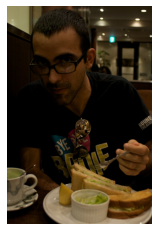

Question : how many eggs are on the plate?
Actual Answer:  0
Top Predicted answers:  [('1', 27.999153), ('2', 24.779943), ('0', 22.504822), ('3', 12.230528), ('4', 6.089961)]
****************************************************************************************************


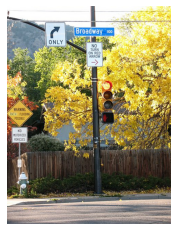

Question : what street is this?
Actual Answer:  broadway
Top Predicted answers:  [('people', 4.9464855), ('steam', 3.3293514), ('cars', 3.1884477), ('police', 2.9643228), ('wooden', 2.2434154)]
****************************************************************************************************


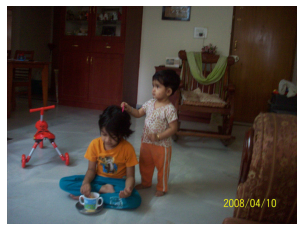

Question : how many people are barefoot?
Actual Answer:  2
Top Predicted answers:  [('2', 32.191265), ('1', 21.558422), ('3', 18.848713), ('4', 10.335643), ('5', 5.608126)]
****************************************************************************************************


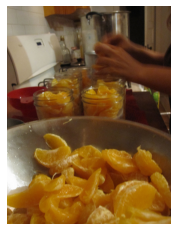

Question : what color is the stove?
Actual Answer:  white
Top Predicted answers:  [('white', 56.918736), ('silver', 16.070456), ('black', 7.9943852), ('blue', 6.148758), ('brown', 3.1214728)]
****************************************************************************************************


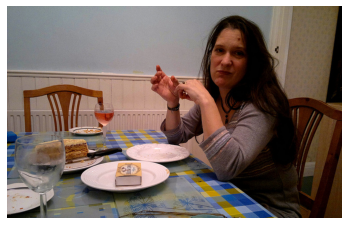

Question : is this woman a smoker?
Actual Answer:  no
Top Predicted answers:  [('yes', 61.89678), ('no', 38.103218), ('1', 7.5366216e-08), ('2', 4.203243e-08), ('night', 2.0391413e-08)]
****************************************************************************************************


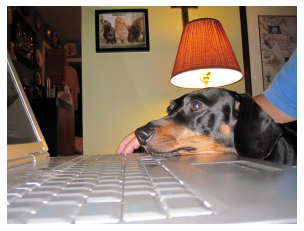

Question : what is the dog laying on?
Actual Answer:  laptop
Top Predicted answers:  [('bed', 24.48577), ('couch', 13.047224), ('chair', 8.518474), ('floor', 8.436351), ('table', 6.735366)]
****************************************************************************************************


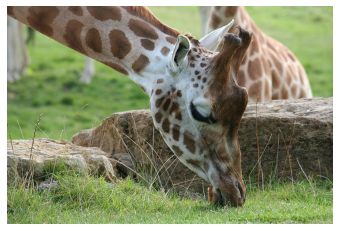

Question : what is the animal doing?
Actual Answer:  eating
Top Predicted answers:  [('eating', 45.413597), ('standing', 27.427153), ('walking', 16.039883), ('resting', 2.0559185), ('sleeping', 1.5567476)]
****************************************************************************************************


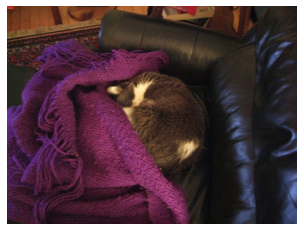

Question : does the cat love the shoe?
Actual Answer:  no
Top Predicted answers:  [('no', 50.462265), ('yes', 49.537727), ('1', 3.653595e-06), ('2', 1.0046496e-06), ('cake', 6.3879384e-07)]
****************************************************************************************************


In [41]:
generate_on_val(model)

In [52]:
print_accuracy_metrics(model)

0it [00:00, ?it/s]

(32, 24, 512) (32, 24, 512) (32, 24, 512)
Tensor("model_7/coattention_model_4/MatMul_3:0", shape=(32, 1, 512), dtype=float32)
Tensor("model_7/coattention_model_4/MatMul_4:0", shape=(32, 1, 512), dtype=float32)
Tensor("model_7/coattention_model_4/MatMul_8:0", shape=(32, 1, 512), dtype=float32)
Tensor("model_7/coattention_model_4/MatMul_9:0", shape=(32, 1, 512), dtype=float32)
Tensor("model_7/coattention_model_4/MatMul_13:0", shape=(32, 1, 512), dtype=float32)
Tensor("model_7/coattention_model_4/MatMul_14:0", shape=(32, 1, 512), dtype=float32)


3349it [25:23,  1.60it/s]

(None, 24, 512) (None, 24, 512) (None, 24, 512)
Tensor("model_7/coattention_model_4/MatMul_3:0", shape=(None, 1, 512), dtype=float32)
Tensor("model_7/coattention_model_4/MatMul_4:0", shape=(None, 1, 512), dtype=float32)
Tensor("model_7/coattention_model_4/MatMul_8:0", shape=(None, 1, 512), dtype=float32)
Tensor("model_7/coattention_model_4/MatMul_9:0", shape=(None, 1, 512), dtype=float32)
Tensor("model_7/coattention_model_4/MatMul_13:0", shape=(None, 1, 512), dtype=float32)
Tensor("model_7/coattention_model_4/MatMul_14:0", shape=(None, 1, 512), dtype=float32)


3350it [25:25,  2.20it/s]
214349it [00:52, 4086.04it/s]


Accuracy : 47.26621848791456
